# Repeat Mode of ``Network``

Another simple but powerful function provided in ``BrainPy`` is the repeat running mode of ``brainpy.Network``. This function allows users to run a compiled network model repeatly. Specifically, each ``brainpy.Network`` is instantiated  in the repeat mode by default. Once, the input structure of the model is changed, the network will be rebiuld and recompiled. 

Before each function call of ``net.run()``, users can arbitrarily set the values in ``ST`` state, or the input values in ``inputs``. However, user's parameter updating ``model.pars['xx'] = xx`` can not be done. This is because BrainPy compiles the ``ST`` and ``inputs`` as dynamical variables and treat them as the functional arguments, while for the ``pars``, BrainPy recognizes them as the static variables and can not be changed after the model compilation.

Repeat mode of ``brainpy.Network`` is very useful at least in the following two situations: *parameter searching* and *RAM memory saving*.

## Parameter Searching

``Parameter searching`` is one of the most common things in computational modeling. When creating a 
model, we'll be presented with many parameters to control how our defined model evolves. Often times, 
we don't immediately know what the optimal parameter set should be for a given model, and thus we'd 
like to be able to explore a range of possibilities. 

Fortunately, with the ``repeat`` mode provided in ``brainpy.Network``, parameter searching is a very easy thing. 

Here, we illustrate this with the example of [gamma oscillation](https://brainpy.readthedocs.io/en/latest/tutorials/quick_start.html), and to see how different value of ``g_max`` (the maximal synaptic conductance) affect the network coherence. 

First, let's import the necessary packages and define the models first.

In [1]:
import sys
sys.path.append('../../')

import brainpy as bp
import numpy as np
import matplotlib.pyplot as plt

bp.profile.set(jit=True, dt=0.04, numerical_method='exponential')

Same with [gamma oscillation](https://brainpy.readthedocs.io/en/latest/tutorials/quick_start.html), the HH neuron model is defined as:

In [2]:
# HH neuron model #
# --------------- #

V_th = 0.
C = 1.0
gLeak = 0.1
ELeak = -65
gNa = 35.
ENa = 55.
gK = 9.
EK = -90.
phi = 5.0

HH_ST = bp.types.NeuState({'V': -55., 'h': 0., 'n': 0., 'spike': 0., 'inp': 0.})

@bp.integrate
def int_h(h, t, V):
    alpha = 0.07 * np.exp(-(V + 58) / 20)
    beta = 1 / (np.exp(-0.1 * (V + 28)) + 1)
    dhdt = alpha * (1 - h) - beta * h
    return phi * dhdt

@bp.integrate
def int_n(n, t, V):
    alpha = -0.01 * (V + 34) / (np.exp(-0.1 * (V + 34)) - 1)
    beta = 0.125 * np.exp(-(V + 44) / 80)
    dndt = alpha * (1 - n) - beta * n
    return phi * dndt

@bp.integrate
def int_V(V, t, h, n, Isyn):
    m_alpha = -0.1 * (V + 35) / (np.exp(-0.1 * (V + 35)) - 1)
    m_beta = 4 * np.exp(-(V + 60) / 18)
    m = m_alpha / (m_alpha + m_beta)
    INa = gNa * m ** 3 * h * (V - ENa)
    IK = gK * n ** 4 * (V - EK)
    IL = gLeak * (V - ELeak)
    dvdt = (- INa - IK - IL + Isyn) / C
    return dvdt

def neu_update(ST, _t):
    h = int_h(ST['h'], _t, ST['V'])
    n = int_n(ST['n'], _t, ST['V'])
    V = int_V(ST['V'], _t, ST['h'], ST['n'], ST['inp'])
    sp = np.logical_and(ST['V'] < V_th, V >= V_th)
    ST['spike'] = sp
    ST['V'] = V
    ST['h'] = h
    ST['n'] = n
    ST['inp'] = 0.

HH = bp.NeuType(name='HH_neuron', ST=HH_ST, steps=neu_update)

Different from the [orignal definition](https://brainpy.readthedocs.io/en/latest/tutorials/quick_start.html), 
here we add the parameter ``g_max`` into the ``ST``, because later we will change the value of ``g_max`` and rerun the model.

In [3]:
# GABAa #
# ----- #

g_max = 0.1
E = -75.
alpha = 12.
beta = 0.1

@bp.integrate
def int_s(s, t, TT):
    return alpha * TT * (1 - s) - beta * s

def syn_update(ST, _t, pre):
    T = 1 / (1 + np.exp(-(pre['V'] - V_th) / 2))
    s = int_s(ST['s'], _t, T)
    ST['s'] = s

def syn_output(ST, post):
    post['inp'] -= ST['g_max'] * ST['s'] * (post['V'] - E)

GABAa = bp.SynType(name='GABAa',
                   ST=bp.types.SynState(['g_max', 's']),
                   steps=(syn_update, syn_output),
                   requires=dict(pre=bp.types.NeuState(['V']),
                                 post=bp.types.NeuState(['V', 'inp'])),
                   mode='scalar')

Putting the HH neuron and the GABA<sub>A</sub> syanpse together, let's define the network in which HH neurons are interconnected with the GABA<sub>A</sub> syanpses. Here, what's different is we add a term ``mode='repeat'`` into the ``bp.Network`` definition.

In [4]:
# Network #
# ------- #

num = 100
v_init = -70. + np.random.random(num) * 20
h_alpha = 0.07 * np.exp(-(v_init + 58) / 20)
h_beta = 1 / (np.exp(-0.1 * (v_init + 28)) + 1)
h_init = h_alpha / (h_alpha + h_beta)
n_alpha = -0.01 * (v_init + 34) / (np.exp(-0.1 * (v_init + 34)) - 1)
n_beta = 0.125 * np.exp(-(v_init + 44) / 80)
n_init = n_alpha / (n_alpha + n_beta)

group = bp.NeuGroup(HH, geometry=num, monitors=['spike'])
conn = bp.SynConn(GABAa, pre_group=group, post_group=group,
                  conn=bp.connect.All2All(include_self=False))
net = bp.Network(group, conn)

Now, by using the [cross correlation](https://en.wikipedia.org/wiki/Cross-correlation) measurement, we can evaluate the network coherence under the different parameter setting of ``g_max``.

In [5]:
# Parameter Searching #
# ------------------- #

all_g_max = np.arange(0.05, 0.151, 0.01) / num
all_cc = []

for i, g_max in enumerate(all_g_max):
    print('When g_max = {:.5f} ...'.format(g_max))
    
    group.ST['V'] = v_init
    group.ST['h'] = h_init
    group.ST['n'] = n_init
    group.ST['spike'] = 0.
    group.ST['inp'] = 0.
    
    conn.ST['s'] = 0.
    conn.ST['g_max'] = g_max
    
    report = i < 2
    net.run(duration=500., inputs=[group, 'ST.inp', 1.2], report=report, report_percent=0.2)

    cc = bp.measure.cross_correlation(group.mon.spike, bin_size=int(0.5 / bp.profile.get_dt()))
    all_cc.append(cc)
    
    if report: print('\n')

When g_max = 0.00050 ...
Compilation used 3.0192 s.
Start running ...
Run 20.0% used 0.658 s.
Run 40.0% used 1.315 s.
Run 60.0% used 1.972 s.
Run 80.0% used 2.632 s.
Run 100.0% used 3.304 s.
Simulation is done in 3.304 s.


When g_max = 0.00060 ...
Compilation used 0.0010 s.
Start running ...
Run 20.0% used 0.669 s.
Run 40.0% used 1.333 s.
Run 60.0% used 1.992 s.
Run 80.0% used 2.661 s.
Run 100.0% used 3.335 s.
Simulation is done in 3.335 s.


When g_max = 0.00070 ...
When g_max = 0.00080 ...
When g_max = 0.00090 ...
When g_max = 0.00100 ...
When g_max = 0.00110 ...
When g_max = 0.00120 ...
When g_max = 0.00130 ...
When g_max = 0.00140 ...
When g_max = 0.00150 ...


As you can see, the network was only compiled at the fist time run. And the overall speed of the later running does not change.

Finally, we can plot the relationship between the ``g_max`` and network coherence ``cc``.

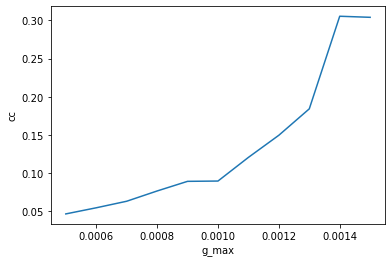

In [6]:
plt.plot(all_g_max, all_cc)
plt.xlabel('g_max')
plt.ylabel('cc')
plt.show()

It is worthy to note that in this example, before each ``net.run()``, we reset the ``ST`` state of the neuron group and the synaptical connection. This is because each repeat run is independent with each other in the case of the parameter tuning. However, in the following example, the current ``net.run()`` relies on the previous network running, the ``ST`` state should not be reset. 

## Memory Saving

Another annoyance often occurs is that our computers have limited RAM memory. Once the model size is big, or the running duration is long, ``MemoryError`` usually occurs. 

Here, with ``brainpy.Network`` repeat running mode, BrainPy can partially solve this problem by allowing uers to split a long duration into multiple short durations. BrainPy allows user to repeatedly call ``run()``, **but with the same ``inputs`` structure**. In this section, we illustrate this function by using the above defined gamma oscillation network.

We define a network with the size of 200 HH neurons, and try to run this network in 2 seconds.

In [7]:
num = 200
v_init = -70. + np.random.random(num) * 20
h_alpha = 0.07 * np.exp(-(v_init + 58) / 20)
h_beta = 1 / (np.exp(-0.1 * (v_init + 28)) + 1)
h_init = h_alpha / (h_alpha + h_beta)
n_alpha = -0.01 * (v_init + 34) / (np.exp(-0.1 * (v_init + 34)) - 1)
n_beta = 0.125 * np.exp(-(v_init + 44) / 80)
n_init = n_alpha / (n_alpha + n_beta)

group = bp.NeuGroup(HH, geometry=num, monitors=['spike'])
conn = bp.SynConn(GABAa, pre_group=group, post_group=group,
                  conn=bp.connect.All2All(include_self=False))
net = bp.Network(group, conn)

group.ST['V'] = v_init
group.ST['h'] = h_init
group.ST['n'] = n_init

conn.ST['g_max'] = 0.1 / num

Here, we do not run the total 2 second at one time. On the contrary, we run the model with four steps, with each step of 0.5 second running duration.

Compilation used 3.2405 s.
Start running ...
Run 20.0% used 2.605 s.
Run 40.0% used 5.107 s.
Run 60.0% used 7.631 s.
Run 80.0% used 10.152 s.
Run 100.0% used 12.653 s.
Simulation is done in 12.653 s.


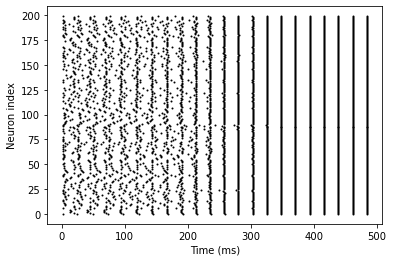

In [8]:
# run 1: 0 - 500 ms

net.run(duration=(0., 500.), inputs=[group, 'ST.inp', 1.2], report=True, report_percent=0.2)
bp.visualize.raster_plot(net.ts, group.mon.spike, show=True)

Compilation used 0.0020 s.
Start running ...
Run 20.0% used 2.500 s.
Run 40.0% used 5.018 s.
Run 60.0% used 7.506 s.
Run 80.0% used 10.019 s.
Run 100.0% used 12.524 s.
Simulation is done in 12.524 s.


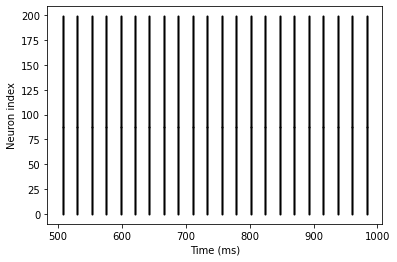

In [9]:
# run 2: 500 - 1000 ms

net.run(duration=(500., 1000.), inputs=[group, 'ST.inp', 1.2], report=True, report_percent=0.2)
bp.visualize.raster_plot(net.ts, group.mon.spike, show=True)

Set a different inputs structure, the network will ne rebuild and recompiled.

The current "ST.inp" input shape (200,) is different from the last input shape (). The network will be recompiled.
The network will be rebuild.
Compilation used 3.0360 s.
Start running ...
Run 20.0% used 2.507 s.
Run 40.0% used 5.002 s.
Run 60.0% used 7.504 s.
Run 80.0% used 10.014 s.
Run 100.0% used 12.521 s.
Simulation is done in 12.521 s.


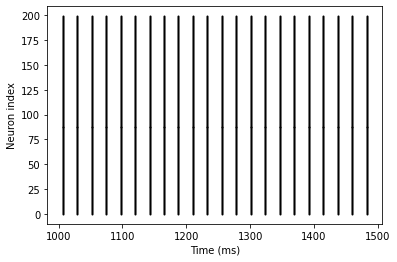

In [10]:
# run 1000 - 1500 ms

Iext = np.ones(num) * 1.2
net.run(duration=(1000., 1500.), inputs=[group, 'ST.inp', Iext], 
        report=True, report_percent=0.2)
bp.visualize.raster_plot(net.ts, group.mon.spike, show=True)

## Notes

Another thing worthy noting is that if the model ``ST`` state relies on the time (for example, the LIF neuron model ``ST['t_last_spike']``). Setting the continuous time duration between each repeat run is necessary, because the model's logic is dependent on the current time ``_t``. However, in this gamma oscillation network, although we set the duration as ``duration=500.`` (not ``duration=(1000., 1500.)``) in the third repeat run, the model will also produce the correct results. This is because the network running logic is independent with the current time ``_t``.